# Single cell ATAC-Seq analysis data by 10x Cell Ranger


_Cell Ranger ATAC-Seq_ https://support.10xgenomics.com/single-cell-atac/software/pipelines/latest/algorithms/overview

Information about library.

<img src='assets/1.png' width=80%>

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Fragments file processing

In [2]:
import re

# Fragments file provided by cell ranger
fragments_file_gz = '/mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/atac/TWDB-T-CIML007-Baseline_NK_snATAC/outs/fragments.tsv.gz'

# BedTools doesn't work with gz file, so unzip it
!gunzip {fragments_file_gz}
fragments_file = re.sub('\.gz', '', fragments_file_gz)

# Print first line of fragments file
with open(fragments_file, 'r') as fin:        
    for line in fin:        
        print(line)
        break

gzip: /mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/atac/TWDB-T-CIML007-Baseline_NK_snATAC/outs/fragments.tsv.gz: No such file or directory
chr1	10073	10369	AGTCCGGGTCAACTGT-1	1



# Cell Calling

_Cell Ranger ATAC-Seq_

Given `peaks.bed` graphics of BARCODE overlaps with peaks.
<img src='assets/2.png' width=80%>

For each barcode, we have the record of mapped high-quality fragments that passed all filters (the fragments.tsv file). Having determined peaks prior to this, we use the number of fragments that overlap any peak regions, for each barcode, to separate the signal from noise. **This works better in practice as compared to naively using the number of fragments per barcode.** We first subtract a depth-dependent fixed count from all barcode counts to model whitelist contamination. This fixed count is the estimated number of fragments per barcode that originated from a different GEM, assuming a contamination rate of 0.02. Then we fit a mixture model of two negative binomial distributions to capture the signal and noise. Setting an odds ratio of 1000, we separate the barcodes that correspond to real cells from the non-cell barcodes.

**We use dumb threshold for now.**

In [3]:
# Intersect using bedtools rather than pybedtools, because they are too slow!
import tempfile
import pandas as pd
import numpy as np
import os
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()


def process_peaks_file(fragments_file, peaks_file, threshold=137):
    ! wc -l {peaks_file}

    idf = None
    ! wc -l {fragments_file}
    with tempfile.NamedTemporaryFile(prefix='intersection', suffix='.bed') as f:
        print('Computing intersection')
        ! bedtools intersect -wa -wb -a {fragments_file} -b {peaks_file} > {f.name}
        ! wc -l {f.name}
        idf = pd.read_csv(f.name, sep='\t', header=None)
        idf.columns = ['chr', 'start', 'end', 'barcode', 'reads', 'peak_chr', 'peak_start', 'peak_end']
    print('Intersection of fragments and peaks')
    print(idf.head())
    pidf = pd.pivot_table(idf, values='reads', index=['barcode'], aggfunc='count')
    pidf.reset_index(level=0, inplace=True)
    print('Barcode vs number of fragments overlapping peaks')
    print(pidf.head())
    
    counts = sorted(pidf['reads'], reverse=True)
    ns = range(1, len(counts) + 1)
    df_all = pd.DataFrame(data={'count': counts, 'n': ns})
    df_cells = df_all.loc[df_all['count'] >= threshold]
    df_noise = df_all.loc[df_all['count'] < threshold]
    print('Filtering cells by threshold', threshold)
    cells = set(pidf.loc[pidf['reads'] >= threshold]['barcode'])
    idfcells = idf.loc[[c in cells for c in idf['barcode']]]
    print('Estimated number of cells', len(df_cells))

    # create a new plot (with a title) using figure
    p = figure(plot_width=400, plot_height=400, title="Plots", x_range=(0, 6))
    p.line(np.log10(df_cells['n']), np.log10(df_cells['count']) , line_width=3, line_color='orange', legend='Cell')
    p.line(np.log10(df_noise['n']), np.log10(df_noise['count']) , line_width=3, line_color='blue', legend='Noise')
    p.legend.location = "center_right"
    p.legend.background_fill_color = "#fefefe"
    p.xaxis.axis_label = 'Barcodes'
    p.yaxis.axis_label = 'Fragments overlapping Peaks'
    show(p)
    
    return idfcells

Loading BokehJS ...

In [4]:
# 10x Cell ranger single cell ATAC-Seq
idf10x = process_peaks_file(
    fragments_file, '/mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/bam/peaks.bed',
    threshold=3000)

67086 /mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/bam/peaks.bed
77486512 /mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/atac/TWDB-T-CIML007-Baseline_NK_snATAC/outs/fragments.tsv
Computing intersection
56077745 /tmp/intersection3yjz87_m.bed
Intersection of fragments and peaks
    chr   start     end             barcode  reads peak_chr  peak_start  \
0  chr1  181305  181465  TACGCAAGTGAGCTAG-1      2     chr1      181389   
1  chr1  181324  181494  GAATCTGGTAACTGAA-1      2     chr1      181389   
2  chr1  181328  181485  TACATGGAGTGAAGGA-1      1     chr1      181389   
3  chr1  181336  181494  GCTCCTACAGCGTGAA-1      1     chr1      181389   
4  chr1  181336  181505  AGCTGGCTCCAATAGC-1      1     chr1      181389   

   peak_end  
0    181537  
1    181537  
2    181537  
3    181537  
4    181537  
Barcode vs number of fragments overlapping peaks
              barcode  reads
0  AAACGAAAGAAACGCC-1      2
1  AAACGAAAGAAAGCAG-1      3
2  AAACGAAAGAAAGGGT-1     

In [5]:
# MACS2 processing like in scatac pipeline ATAC-Seq
# MACS2 --no-model --p 1e-4
# idfmacs = process_peaks_file(
#     fragments_file, '/mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/bam/macs2_p1e-4.narrowPeak',
#     threshold=20000)

In [6]:
# SPAN - --fragment 0 --keep-dup --bin 100
# idfspan = process_peaks_file(
#     fragments_file, 
#     '/mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/bam/span_f0_kd_bin100_fdr1.0E-6_gap5.bed',
#     threshold=2000)

# Peak-Barcode Matrix

_Cell Ranger ATAC-Seq_

We produce a count matrix consisting of the counts of fragment ends (or cut sites) within each peak region for each barcode. This is the raw peak-barcode matrix and it captures the enrichment of open chromatin per barcode. The matrix is then filtered to consist of only cell barcodes, which is then used in subsequent analysis such as dimensionality reduction, clustering and visualization.

In [7]:
idf = idf10x

pdf = pd.pivot_table(idf, values='reads', 
                     index=['peak_chr', 'peak_start', 'peak_end', 'barcode'], aggfunc=np.sum).reset_index()
pdf['peak'] = pdf['peak_chr'] + ':' + pdf['peak_start'].astype(str) + '-' + pdf['peak_end'].astype(str)
pdf.drop(columns=['peak_chr', 'peak_start', 'peak_end'], inplace=True)
print('Barcode vs summary fragments overlap with peaks')
pdf.head()

Barcode vs summary fragments overlap with peaks


barcode  reads                peak
0  AAAGATGCACTCCCAT-1      3  chr1:181389-181537
1  AACAGTCGTTGTGACT-1      2  chr1:181389-181537
2  AAGATAGAGGTAGGAA-1      5  chr1:181389-181537
3  AGCTGGCTCCAATAGC-1      1  chr1:181389-181537
4  AGCTGGCTCTGGACAT-1      1  chr1:181389-181537

In [8]:
fulldf = pd.pivot_table(pdf, index='peak', columns='barcode', values='reads').fillna(0)
# Remove extra labels from pivot_table columns
fulldf.columns = fulldf.columns.values
fulldf.index.name = None
fulldf.head()

AAACGAAAGACTAATG-1  AAACGAAAGAGGTGGG-1  \
chr10:100006265-100006798                 0.0                 0.0   
chr10:100009106-100010528                 0.0                 0.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-100046443                 0.0                 0.0   
chr10:100167463-100168096                 1.0                 0.0   

                           AAACGAAAGGGCTTCC-1  AAACGAAAGTATGGGC-1  \
chr10:100006265-100006798                 0.0                 0.0   
chr10:100009106-100010528                 0.0                 0.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-100046443                 0.0                 0.0   
chr10:100167463-100168096                 0.0                 0.0   

                           AAACGAAAGTGTTCCA-1  AAACGAAAGTTCGCGC-1  \
chr10:100006265-100006798                 0.0                 0.0   
chr10:100009106-100010528                 1.0                 1.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-100046443                 0.0                 0.0   
chr10:100167463-100168096                 0.0                 0.0   

                           AAACGAACAATAGTGA-1  AAACGAACACATATCG-1  \
chr10:100006265-100006798                 0.0                 1.0   
chr10:100009106-100010528                 0.0                 0.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-100046443                 1.0                 0.0   
chr10:100167463-100168096                 0.0                 0.0   

                           AAACGAACACGCGTTG-1  AAACGAACATCCATAG-1  \
chr10:100006265-100006798                 0.0                 0.0   
chr10:100009106-100010528                 0.0                 1.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-100046443                 0.0                 0.0   
chr10:100167463-100168096                 0.0                 0.0   

                                  ...          TTTGTGTAGCATGATA-1  \
chr10:100006265-100006798         ...                         0.0   
chr10:100009106-100010528         ...                         0.0   
chr10:100020324-100020915         ...                         0.0   
chr10:100045984-100046443         ...                         0.0   
chr10:100167463-100168096         ...                         2.0   

                           TTTGTGTCAAGTCTCA-1  TTTGTGTCACAACGGA-1  \
chr10:100006265-100006798                 0.0                 0.0   
chr10:100009106-100010528                 0.0                 0.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-100046443                 0.0                 0.0   
chr10:100167463-100168096                 0.0                 0.0   

                           TTTGTGTGTACCTATG-1  TTTGTGTGTGATGCGA-1  \
chr10:100006265-100006798                 0.0                 0.0   
chr10:100009106-100010528                14.0                 0.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-100046443                 0.0                 0.0   
chr10:100167463-100168096                 0.0                 0.0   

                           TTTGTGTGTGCCCAGT-1  TTTGTGTGTTTGATCG-1  \
chr10:100006265-100006798                 0.0                 0.0   
chr10:100009106-100010528                 0.0                 0.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-100046443                 0.0                 0.0   
chr10:100167463-100168096                 0.0                 0.0   

                           TTTGTGTTCATCGCCT-1  TTTGTGTTCGCTATAG-1  \
chr10:100006265-100006798                 0.0                 0.0   
chr10:100009106-100010528                 6.0                 1.0   
chr10:100020324-100020915                 0.0                 0.0   
chr10:100045984-

# Dimensionality Reduction, Clustering and t-SNE Projection

_Cell Ranger ATAC-Seq_

<img src='assets/3.png' width=80%>

The adopted default method is LSA.

**PCA**

For PCA, we first normalize the data to median cut site counts per barcode and log-transform it. We use a fast, scalable and memory efficient implementation of IRLBA (Augmented, Implicitly Restarted Lanczos Bidiagonalization Algorithm) that allows in-place centering and feature scaling and produces the transformed matrix along with the principal components (PC) and singular values encoding the variance explained by each PC. 
Specific to PCA, we provide k-means clustering that produces 2 to 10 clusters for visualization and analysis. We also provide a k-nearest neighbors graph-based clustering method via community detection using louvain modularity optimization algorithm. 

**LSA**

Inspired by the large body of work in the field of information retrieval, we normalize the data via the inverse-document frequency (idf) transform where each peak count is scaled by the log of the ratio of the number of barcodes in the matrix and the number of barcodes where the peak has a non-zero count. This provides greater weight to counts in peaks that occur in fewer barcodes. LSA aka SVD.
Singular value decomposition (SVD) is performed on this normalized matrix using IRLBA without scaling or centering, and produce the transformed matrix in lower dimensional space, as well as the components and the singular values signifying the importance of each component. Prior to clustering, we perform normalization to depth by scaling each barcode data point to unit L2-norm in the lower dimensional space. We found that the combination of these normalization techniques obviates the need to remove the first component. Specific to LSA, we provide k-medoids clustering that produces 2 to 10 clusters for downstream analysis. k-medoids was found to perform better than k-means on identifying correct clusters on the spherical manifold which is where the data lives after normalizing to unit norm. Similar to PCA, we also provide a graph-based clustering and visualization via t-SNE. However, similar to k-medoids clustering, we normalize the data to unit norm before performing graph-based clustering and t-SNE projection.

**t-SNE**

The transformed matrix is operated on by the t-SNE algorithm with default parameters and provides 2-D coordinates for each barcode for visualization. We also provide an optimized implementation of the Barnes Hut TSNE algorithm (which is the same as the one in our analysis pipeline for the Single Cell Gene Expression Solution). The number of dimensions is fixed to 15 as it was found to sufficiently separate clusters visually and in a biologically meaningful way when tested on peripheral blood mononuclear cells (PBMCs).



## Identification of highly variable features (feature selection)

_Seurat single cell pipeline_ https://satijalab.org/seurat/v3.0/pbmc3k_tutorial.html

We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). We and others have found that focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.

<img src='assets/4.png' width=30%>

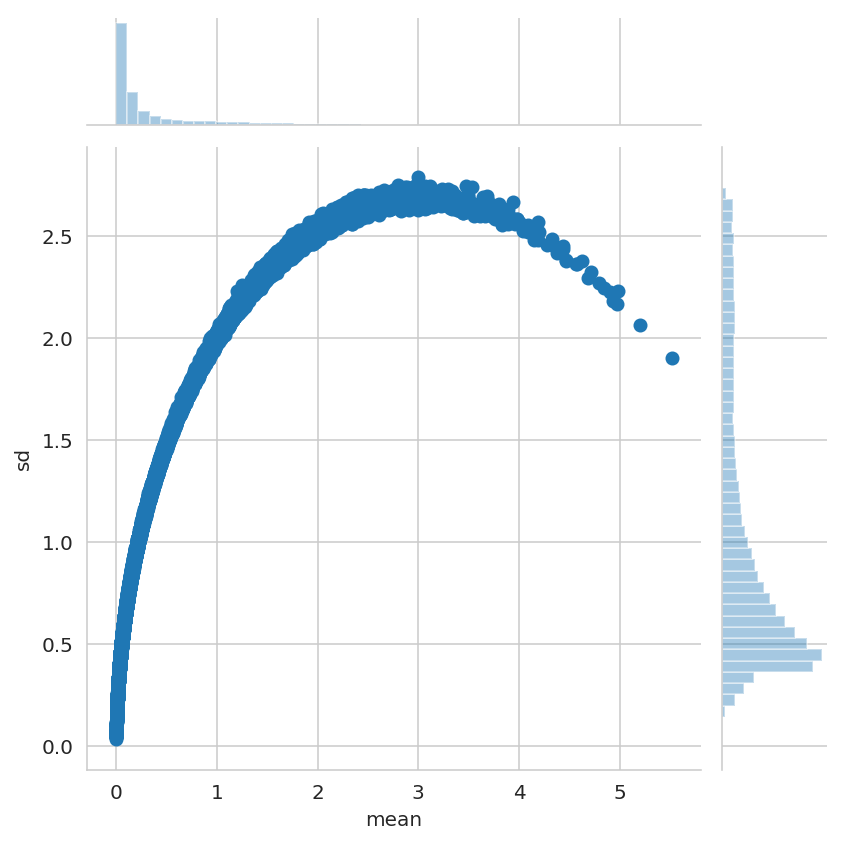

Total peaks 67083
Filtered peaks 25461


In [9]:
def feature_selection(fulldf):
    """Mean vs SD for peaks"""
    t = fulldf.copy()
    # RPM like normalization for read counts
    # print(t.sum().head())
    t = t / t.sum() * 1e6
    # and log-transform it
    t = np.log(t + 1)
    t = t.transpose()
    # print(t.mean().head())
    msdf = pd.DataFrame({'mean': t.mean(), 'sd': np.sqrt(t.var())})

    plt.figure(figsize=(8, 8))
    sns.jointplot(x="mean", y="sd", data=msdf)
    plt.show()

    # Filtration of peaks with small coverage
    mean_threshold = 0.2
    peaks_filter = msdf['mean'] > mean_threshold
    print('Total peaks', len(msdf))
    print('Filtered peaks', sum(peaks_filter))
    return peaks_filter

peaks_filter = feature_selection(fulldf)

In [19]:
from sklearn.decomposition import PCA

def pca(fulldf):
    print('Normalizing')
    normalized = fulldf.copy()
    # RPM like normalization
    normalized = normalized / normalized.sum() * 10e6
    # and log-transform it
    normalized = np.log(normalized + 1)

    normalized = normalized.transpose() # Transpose to (barcodes x peaks) format

    # NOTE: use MaxAbsScaler to preserve sparsity feature of the martix
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled = scaler.fit_transform(normalized.values) # X : numpy array of shape (n_samples, n_features)
    normalized = pd.DataFrame(scaled, index=normalized.index, columns=normalized.columns)

    # Number of dimensions recommended by Cell Ranger ATAC-Seq algorithm
    print('PCA')
    pca = PCA(n_components=15)
    result = pca.fit_transform(normalized) # X : array-like, shape (n_samples, n_features)
    print('Explained variation', np.sum(pca.explained_variance_ratio_))
    return result

In [20]:
from sklearn.decomposition import TruncatedSVD

def lsa(fulldf):
    print('Inverse Document Frequency')
    normalized = fulldf.copy()

    # Inverse Document Frequency
    # Each peak count is scaled by the log of the ratio of the number of barcodes in the matrix 
    # and the number of barcodes where the peak has a non-zero count.
    #  This provides greater weight to counts in peaks that occur in fewer barcodes.
    normalized = normalized.replace([0.0], np.NaN)
    idf = np.log(len(normalized) / normalized.count())
    normalized = normalized * idf
    normalized = normalized.replace([np.NaN], 0.0)
    normalized = normalized.transpose() # Transpose to (barcodes x peaks) format

    # Number of dimensions recommended by Cell Ranger ATAC-Seq algorithm
    print('SVD')
    svd = TruncatedSVD(n_components=15)
    result = svd.fit_transform(normalized)
    print('Explained variation', np.sum(svd.explained_variance_ratio_))
    return result

Normalizing
PCA
Explained variation 0.03150291918004698
Clustering 10
Cluster 0 2131
Cluster 1 583
Cluster 2 239
Cluster 3 98
Cluster 4 2362
Cluster 5 1542
Cluster 6 1
Cluster 7 276
Cluster 8 134
Cluster 9 46


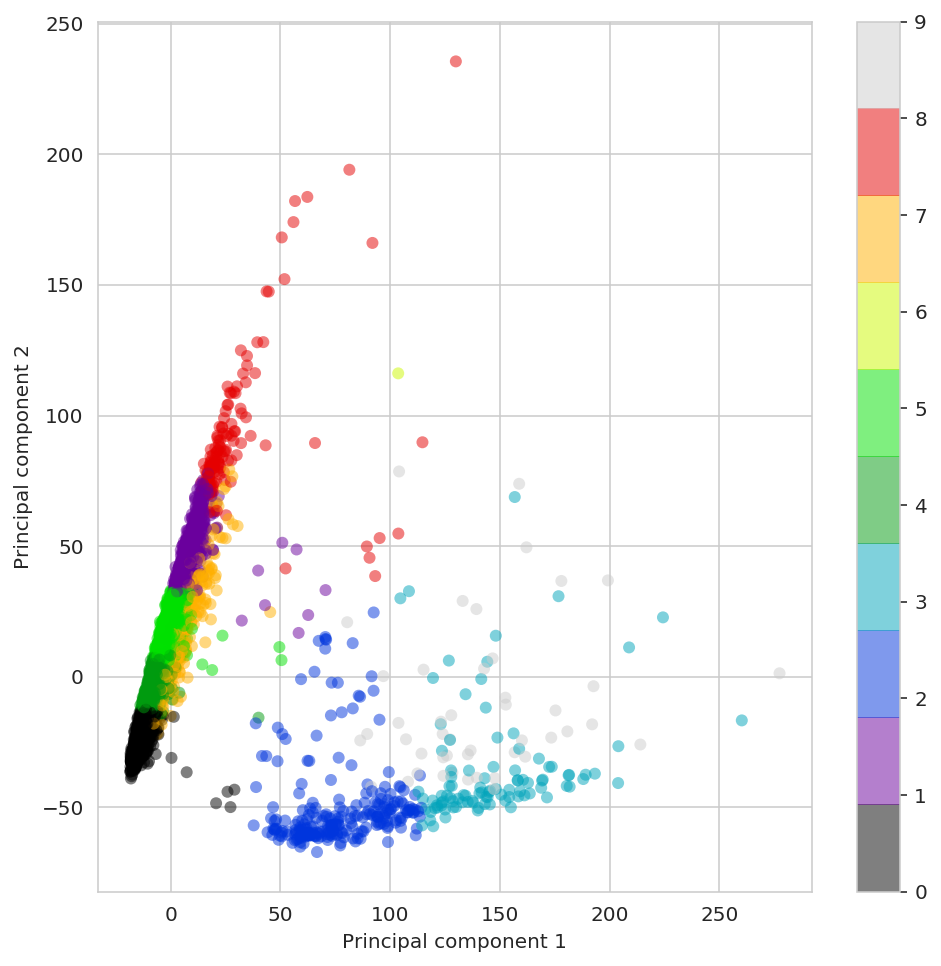

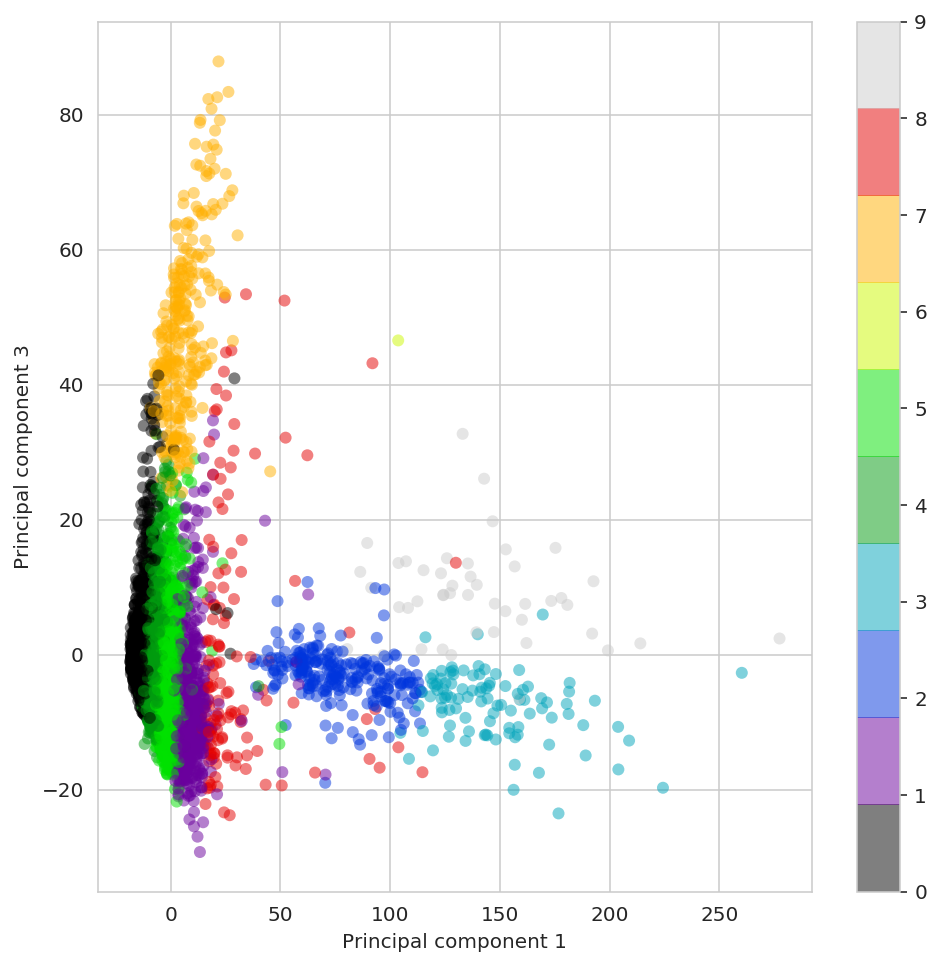

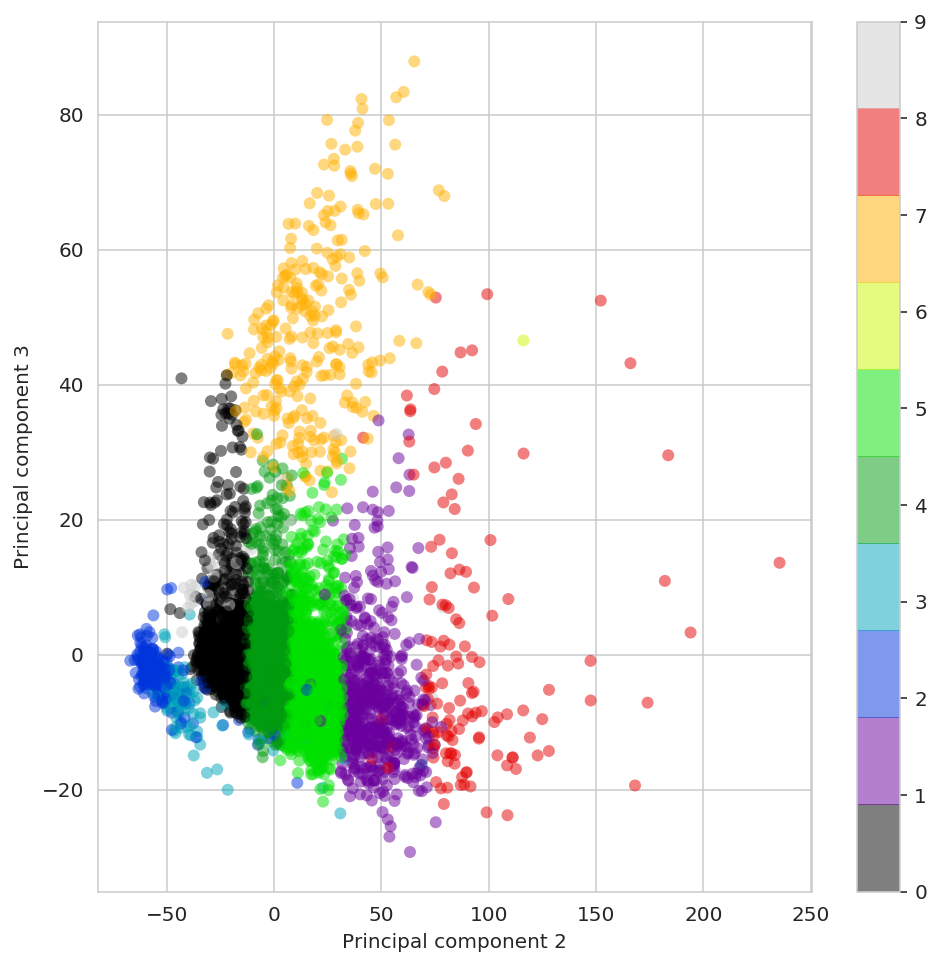

In [21]:
from collections import Counter
from sklearn.cluster import KMeans
import time


# Use PCA dimensionality reduction
# result = pca(fulldf.loc[peaks_filter])
result = pca(fulldf)

# 2-10 clusters is recommened values by Cell Ranger ATAC-Seq
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(result)
y_kmeans = kmeans.predict(result)
cluster_counter = Counter()
for c in y_kmeans:
    cluster_counter['Cluster {}'.format(c)] +=1
print('Clustering', n_clusters)
for c, n in sorted(cluster_counter.items()):
    print(c, n)
    
cmap = plt.cm.get_cmap('nipy_spectral', len(set(y_kmeans)))
for c1,c2 in [(0, 1), (0, 2), (1, 2)]:
    plt.figure(figsize=(8, 8))
    plt.scatter(result[:, c1], result[:, c2], 
                c=y_kmeans, cmap=cmap, 
                edgecolor='none', alpha=0.5)
    plt.xlabel('Principal component {}'.format(c1 + 1))
    plt.ylabel('Principal component {}'.format(c2 + 1))
    plt.colorbar()
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7412 samples in 0.006s...
[t-SNE] Computed neighbors for 7412 samples in 1.318s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7412
[t-SNE] Computed conditional probabilities for sample 2000 / 7412
[t-SNE] Computed conditional probabilities for sample 3000 / 7412
[t-SNE] Computed conditional probabilities for sample 4000 / 7412
[t-SNE] Computed conditional probabilities for sample 5000 / 7412
[t-SNE] Computed conditional probabilities for sample 6000 / 7412
[t-SNE] Computed conditional probabilities for sample 7000 / 7412
[t-SNE] Computed conditional probabilities for sample 7412 / 7412
[t-SNE] Mean sigma: 3.617261
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.070045
[t-SNE] Error after 1000 iterations: 1.748220
t-SNE done! Time elapsed 266.73297810554504


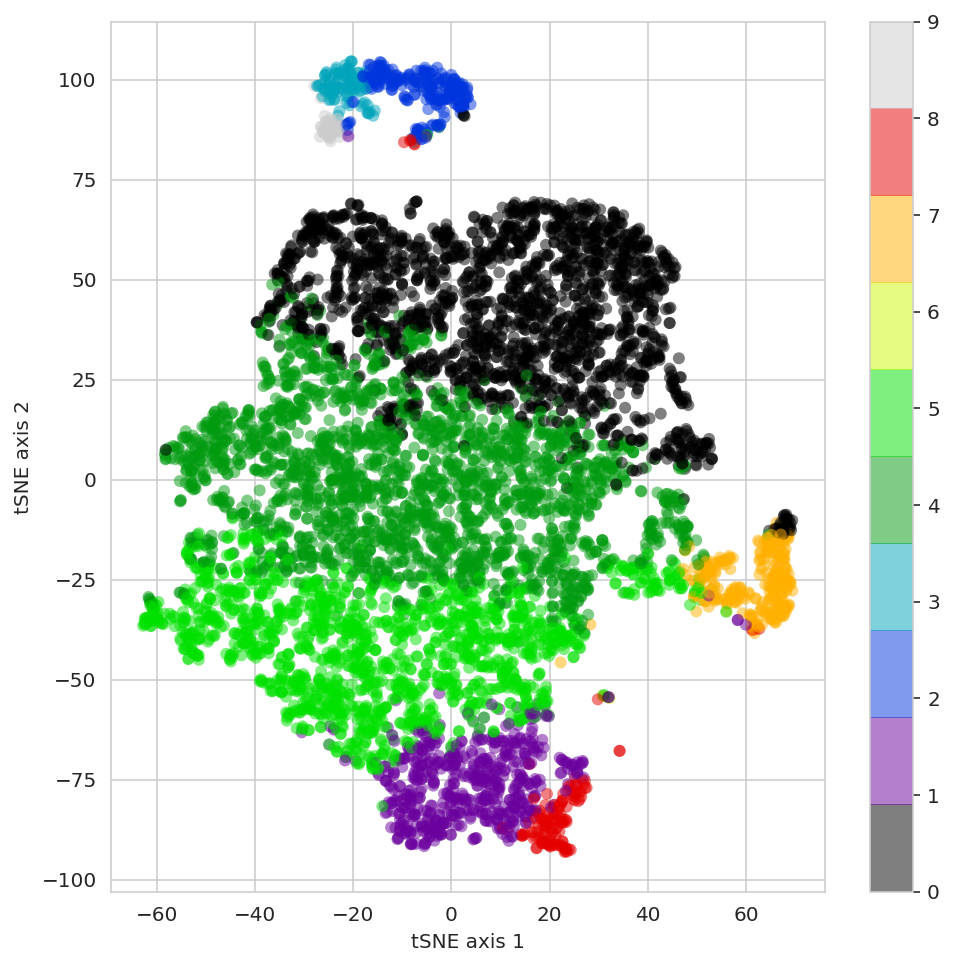

In [22]:
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(result)
print('t-SNE done! Time elapsed', time.time() - time_start)

plt.figure(figsize=(8, 8))
plt.scatter(tsne_results[:,0], tsne_results[:,1], 
            c=y_kmeans, cmap=cmap,
            edgecolor='none', alpha=0.5)
plt.xlabel('tSNE axis 1')
plt.ylabel('tSNE axis 2')
plt.colorbar()
plt.show()

# Preparation the data for single cell explorer
Preprocess data for single cell explorer http://artyomovlab.wustl.edu/shiny/single_cell_explorer

In [23]:
from scipy import io, sparse

print('Save data_for_plot.tsv')
barcodes = fulldf.transpose().index.values
data_for_plot = pd.DataFrame(
    {'tSNE_1': tsne_results[:,0], 
     'tSNE_2': tsne_results[:,1], 
     'Cluster': y_kmeans,
     'nCounts': fulldf.sum()})
data_for_plot.index = barcodes
data_for_plot.to_csv('data_for_plot.tsv', sep='\t')

print('Save expData.Rda.mtx')
# This produces huge tsv file
# fulldf.to_csv('expData.Rda.tsv', sep='\t')
csc = sparse.csc_matrix(fulldf.values)
io.mmwrite('expData.Rda.mtx', csc)

print('Save barcodes.txt')
with open('barcodes.txt', 'w') as f:
    for b in fulldf.columns.values:
        f.write(b + '\n')

print('Save peaks.txt')
with open('peaks.txt', 'w') as f:
    for p in fulldf.index.values:
        f.write(p + '\n')
        
print('Done')

Save data_for_plot.tsv
Save expData.Rda.mtx
Save barcodes.txt
Save peaks.txt
Done


## Convert to Rda format in R
```
require(readr)
require(Matrix)
library(magrittr)

barcodes <- readr::read_tsv('barcodes.txt', col_names = F)
peaks <- readr::read_tsv('peaks.txt', col_names = F)
expData <- Matrix::readMM('expData.Rda.mtx') %>%
    magrittr::set_rownames(peaks$X1) %>%
    magrittr::set_colnames(barcodes$X1)
save(expData, file = "expData.Rda")
```

Upload `data_for_plot.tsv` and `expData.Rda` to corresponding folder and voila! It works.

# Create BED files for clusters

In [24]:
import os
import shutil

fulldft = fulldf.transpose()
results_dir = 'peaks_clusters'
if os.path.exists(results_dir):
    print('Cleanup', results_dir)
    shutil.rmtree(results_dir)

os.mkdir(results_dir)
for c in range(0, n_clusters):
    peaksdf = fulldft.loc[y_kmeans == c].mean()
    bed_file = os.path.join(results_dir, 'cluster_{}.bed'.format(c))
    print('Writing cluster', c, 'peaks to', bed_file)
    with open(bed_file, 'w') as bed:
        for (i, x) in enumerate(peaksdf):
            if x >= 1: 
                bed.write(re.sub(':|-', '\t', peaksdf.index[i]) + '\n')
print('Done')                

Cleanup peaks_clusters
Writing cluster 0 peaks to peaks_clusters/cluster_0.bed
Writing cluster 1 peaks to peaks_clusters/cluster_1.bed
Writing cluster 2 peaks to peaks_clusters/cluster_2.bed
Writing cluster 3 peaks to peaks_clusters/cluster_3.bed
Writing cluster 4 peaks to peaks_clusters/cluster_4.bed
Writing cluster 5 peaks to peaks_clusters/cluster_5.bed
Writing cluster 6 peaks to peaks_clusters/cluster_6.bed
Writing cluster 7 peaks to peaks_clusters/cluster_7.bed
Writing cluster 8 peaks to peaks_clusters/cluster_8.bed
Writing cluster 9 peaks to peaks_clusters/cluster_9.bed
Done
